In [30]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli
import json
import warnings; warnings.simplefilter('ignore')
from tqdm.auto import tqdm
from utils import opt_mean_tuning, make_ess_coverage_plot_intro
from training import train_tree, train_tree_2
from utils_optimization import MinMaxOptimizer_l2, constraint_cross_validation_bias
import torch
import xgboost as xgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
data = pd.read_csv('data/bias_dataset.csv')
data = data.sample(frac=1).reset_index(drop=True) # shuffle data
leaning = 'right' # 'left' or 'right'
Yhat_string = data["label_gpt4o"].to_numpy()
Y_string = data["bias_text"].to_numpy()
confidence = data["confidence_in_prediction_gpt-4o"].to_numpy()
nan_indices = list(np.where(pd.isna(confidence))[0]) + list(np.where(pd.isna(Yhat_string))[0])
good_indices = list(set(range(len(data))) - set(nan_indices))
confidence = confidence[good_indices]
Yhat_string = Yhat_string[good_indices]
Y_string = Y_string[good_indices]
n = len(Yhat_string)
if leaning=='left':
    dict = {"A" : 1, "B" : 0, "C" : 0, "left" : 1, "center": 0, "right": 0}
elif leaning=='right':
    dict = {"A" : 0, "B" : 0, "C" : 1, "left" : 0, "center": 0, "right": 1}
Yhat = np.array([dict[Yhat_string[i]] for i in range(n)])
Y = np.array([dict[Y_string[i]] for i in range(n)])
confidence = confidence.reshape(len(confidence),1)

In [ ]:
bi = 200 
n_rem = n - bi
tree = train_tree_2(confidence[:bi], np.abs((Y - Yhat)[:bi]))
error = tree.predict(confidence[bi:])
uncertainties = (1 - confidence[bi:]).reshape(-1)
uncertainties = (1 - 2 * np.abs(confidence[bi:] - 0.5)).reshape(-1)

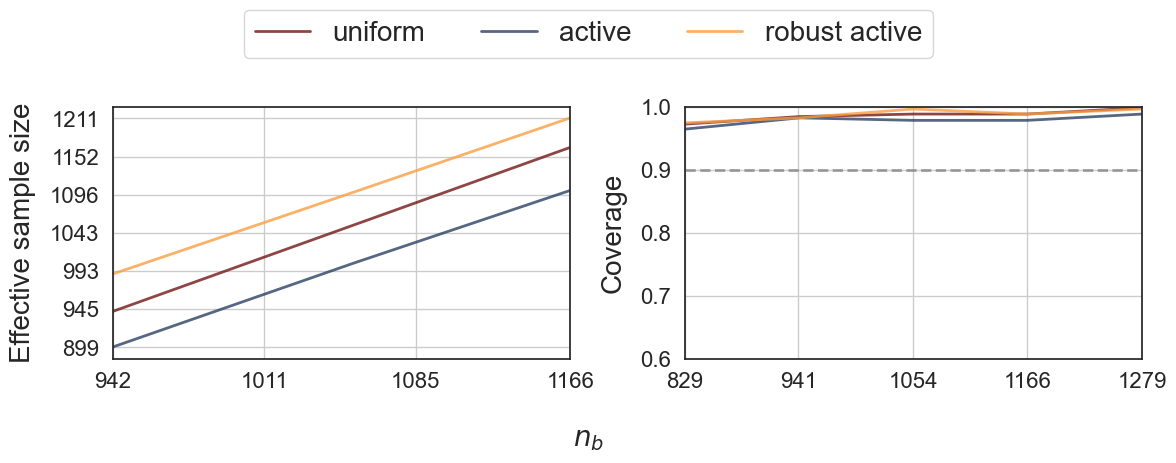

In [ ]:
alpha = 0.1  # desired error level for confidence interval
num_trials = 500

true_prevalence = np.mean(Y)

num_methods = 3
temp_df = pd.DataFrame({
    "lb": np.zeros(num_methods),
    "ub": np.zeros(num_methods),
    "interval width": np.zeros(num_methods),
    "coverage": np.zeros(num_methods),
    "estimator": [""] * num_methods,
    "$n_b$": np.zeros(num_methods),
})

Yhat_ = Yhat.copy()
label = Y[:bi]
budgets = np.linspace(0.35, 0.6, 10)
cv_list = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3]
k = 5 
c_list = constraint_cross_validation_bias(confidence[:bi], Y[:bi], Yhat[:bi], cv_list, k, budgets, device)

tau_list = []
n_rem = len(error)
for i in range(len(budgets)):
    constraint_sum = c_list[i] * np.sqrt(n_rem)
    bg = budgets[i]
    eta = bg / np.mean(uncertainties)
    pi = np.clip(eta*uncertainties, 0.0, 1.0)
    nb = bg * n_rem
    optimizer = MinMaxOptimizer_l2(error, pi, nb, n_rem, constraint_sum)
    optimal_value, optimal_r= optimizer.optimize()
    tau_list.append(optimal_r)

results = []

for j in range(len(budgets)):
    bg = budgets[j]
    
    for i in range(num_trials):
        
        weights_active = np.zeros(n)
        weights_active[:bi] = 1

        sampling_prob = uncertainties/np.mean(uncertainties)*bg
        sampling_prob = np.clip(sampling_prob, 0, 1)

        tau = 0.01
        prob_1 = np.clip((1-tau)*sampling_prob + tau*bg, 0, 1)     
        tau = tau_list[j]
        prob_2 = np.clip(sampling_prob ** (1-tau) * bg ** tau / np.sum(sampling_prob ** (1-tau) * bg ** tau) * (bg) * (n - bi), 0.0, 1.0)

        weights_active[bi:] = bernoulli.rvs(prob_1)/prob_1
        

        
        xi_unif = bernoulli.rvs([bg] * n_rem)
        unif_label = Yhat[bi:] + (Y[bi:]-Yhat[bi:])*xi_unif/bg
        unif_label = np.concatenate([label, unif_label])
        pointest = np.mean(unif_label)
        varhat = np.var(unif_label)
        l = pointest - norm.ppf(1-alpha/2)*np.sqrt(varhat/n)
        u = pointest + norm.ppf(1-alpha/2)*np.sqrt(varhat/n)
        coverage = (true_prevalence >= l)*(true_prevalence <= u)
        temp_df.loc[0] = l, u, u-l, coverage, "uniform", int(n_rem*bg + bi)
        
        sampling_ratio = (1-prob_1)/prob_1
        lam = opt_mean_tuning(Y[bi:], Yhat[bi:], weights_active[bi:], sampling_ratio)
        Yhat_ = lam * Yhat
        active_label = Yhat_[bi:] + (Y[bi:]-Yhat_[bi:])*weights_active[bi:]
        active_label = np.concatenate([label, active_label])
        pointest = np.mean(active_label)
        varhat = np.var(active_label)
        l = pointest - norm.ppf(1-alpha/2)*np.sqrt(varhat/n)
        u = pointest + norm.ppf(1-alpha/2)*np.sqrt(varhat/n)
        coverage = (true_prevalence >= l)*(true_prevalence <= u)
        temp_df.loc[1] = l, u, u-l, coverage, "active", int(n_rem*bg + bi)
        
        


        weights_active[bi:] = bernoulli.rvs(prob_2)/np.clip(prob_2, 0.0, 1.0)
        robust_label = Yhat[bi:] + (Y[bi:]-Yhat[bi:])*weights_active[bi:]
        robust_label = np.concatenate([label, robust_label])
        pointest = np.mean(robust_label)
        varhat = np.var(robust_label)
        l = pointest - norm.ppf(1-alpha/2)*np.sqrt(varhat/n)
        u = pointest + norm.ppf(1-alpha/2)*np.sqrt(varhat/n)
        coverage = (true_prevalence >= l)*(true_prevalence <= u)
        temp_df.loc[2] = l, u, u-l, coverage, "robust active", int(n_rem*bg + bi)





        
        results += [temp_df.copy()]

        

df = pd.concat(results,ignore_index=True)
df["coverage"] = df["coverage"].astype(bool)

make_ess_coverage_plot_intro(df, "prevalence $p_{\mathrm{" + 'right' + "}}$", "llm_bias_ess_coverage_right.pdf", true_prevalence)